Putting it together exercise

In [1]:
import sys
!{sys.executable} -m pip install -I networkx


ERROR: Could not find a version that satisfies the requirement networkx (from versions: none)
ERROR: No matching distribution found for networkx


In [3]:

nx.__version__

'2.8.8'

In [209]:
import sys
!{sys.executable} -m pip install shapely

     ---------------------------------------- 1.4/1.4 MB 17.4 MB/s eta 0:00:00


In [90]:
# First, import important modules. 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from bresenham import bresenham
import utm
from enum import Enum
%matplotlib inline
from queue import PriorityQueue
import pandas as pd
from skimage.morphology import medial_axis
from skimage.util import invert
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Polygon, Point
from shapely import STRtree
from sklearn.neighbors import KDTree
import networkx as nx
import time

In [2]:
coords = np.array([[0, 0, 1],[1, 0, 1],[1, 1, 1],[0, 1, 1]])
poly = Polygon(coords)
print(poly.area)
print(poly.length)
print(poly.bounds)
p1 = Point(0.5, 0.5,11.5)
p2 = Point(1.5, 1.5, 1)
print(poly.contains(p1))
print(poly.contains(p2))

tree = KDTree(coords)
print(tree)
dist, ind = tree.query([np.array([0.5, 0.5, 5])], k=3)
print(dist)
print(ind)

1.0
4.0
(0.0, 0.0, 1.0, 1.0)
True
False
[[4.0620192 4.0620192 4.0620192]]
[[2 0 1]]


In [3]:
x = np.array([1,1])
s = np.array([[5,5], 
              [3,3], 
              [0,0], 
              [10,10]])
print(s.shape)
t = KDTree(s)
d, i = t.query(np.array([x]),k=4)
print(d)
print(i)

(4, 2)
[[ 1.41421356  2.82842712  5.65685425 12.72792206]]
[[2 1 0 3]]


In [4]:
n = np.array([[5,5], [2,2]])
print(n.shape)
print(n[0].shape)
print(n[0])
print(n[:1].shape)
print(n[:1])

(2, 2)
(2,)
[5 5]
(1, 2)
[[5 5]]


In [91]:
def read_obstacle_data(filename):
    """
    This function returns a nx6 numpy array containing obstacle geometry. Each row of the data numpy
            array contains columns with this information: PosX, PosY, PosZ, HalfX, HalfY, HalfZ.
    The function takes as input the string file name for an obstacle CSV file. 
    """
    data = np.loadtxt(filename, delimiter=',', skiprows=2)
    
    return data
    
def create_configuration(data, drone_altitude=10, safety=1):
    """
    Inputs: 
        data: n x 6 numpy array, contains obstacle geometry. Each row of the data numpy
            array contains columns with this information: PosX, PosY, PosZ, HalfX, HalfY, HalfZ.
        drone_altitude: drone altitude, meters above ground
        safety_distance: safety distance, meters of padding around obstacles. 
    Returns: 
        grid: n x m numpy boolean array, representing a grid-based map, where each cell
            is either tagged obstacle (1 = True) or free space (0 = False). Each grid cell is
            equivalent to a 1m x 1m square in space.
        edges: a list of lists of 2-tuples, each providing the start and end coordinates
            of the on-grid vertices not intersecting obstacles generated by 
            a Voronoi algorithm.
    """
    # First, measure the dimensions of the obstacle data.
    r = [0,0,0,0,0,0]
    r[0] = int(np.floor(np.amin(data[:,0] - data[:,3]))) - safety #North min
    r[1] = int(np.ceil(np.amax(data[:,0] + data[:,3]))) + safety #North max
    r[2] = int(np.floor(np.amin(data[:,1] - data[:,4]))) - safety #East min
    r[3] = int(np.ceil(np.amax(data[:,1] + data[:,4]))) + safety #East max
    r[4] = int(np.floor(np.amin(data[:,2] - data[:,5]))) - safety #Alt min
    r[5] = int(np.ceil(np.amax(data[:,2] + data[:,5]))) + safety #Alt max
    offset = [0,0,0]
    offset[0] = int(np.amin(data[:,0])) #North offset
    offset[1] = int(np.amin(data[:,1])) #East offset
    offset[2] = int(np.amin(data[:,2])) #Down offset
    
    # Calculate the size of the configuration space next.
    s = [0,0,0]
    s[0] = r[1] - r[0] 
    s[1] = r[3] - r[2]
    s[2] = r[5] - r[4]
    
    # After that, initialize the configuration space.
    configuration = np.zeros((s[0], s[1]), dtype=float)
    configuration_25d = np.zeros((s[0], s[1]), dtype=float)
    
    # Populate the configuration space with obstacles. Also, obstacle locations will serve as both Voronoi points and Shapely polygon vertices.
    points = []
    obstacle = [0,0,0,0]
    
    for i in range(data.shape[0]):
        north, east, down, d_north, d_east, d_down = data[i,:]          
            
        if drone_altitude < down + d_down:
            obstacle = [
                int(north - offset[0] - d_north - safety),
                int(north - offset[0] + d_north + safety),
                int(east - offset[1] - d_east - safety),
                int(east - offset[1] + d_east + safety)
            ]
            height = down + d_down
            configuration[obstacle[0]:obstacle[1]+1, obstacle[2]:obstacle[3]+1] = 1
            configuration_25d[obstacle[0]:obstacle[1]+1, obstacle[2]:obstacle[3]+1] = height - offset[2]
            points.append((int(north - offset[0]), int(east - offset[1])))

    
    voronoi = Voronoi(points)

    # From the Voronoi graph, extract edges that are safe to fly.
    edges = []
    for v in voronoi.ridge_vertices:
        p1 = voronoi.vertices[v[0]] # Look up index of one end of the edge
        p2 = voronoi.vertices[v[1]] # and then the other. Then get coordinates.
        x1 = int(p1[0])
        y1 = int(p1[1])
        x2 = int(p2[0])
        y2 = int(p2[1])
        trace = bresenham(x1,y1,x2,y2)
        hit = False
        for p in trace:
            if p[0] < 0 or p[0] >= s[0] or p[1] < 0 or p[1] >= s[1]:
                hit = True
            if not hit:
                if configuration[p[0], p[1]] == 1:
                    hit = True
        if not hit:
            edges.append( ((x1, y1),(x2, y2)) )

    return configuration, configuration_25d, edges, s

def extract_polygons(data, safety=1):
    # First, measure the dimensions of the obstacle data.
    r = [0,0,0,0,0,0]
    r[0] = int(np.floor(np.amin(data[:,0] - data[:,3]))) - safety #North min
    r[1] = int(np.ceil(np.amax(data[:,0] + data[:,3]))) + safety #North max
    r[2] = int(np.floor(np.amin(data[:,1] - data[:,4]))) - safety #East min
    r[3] = int(np.ceil(np.amax(data[:,1] + data[:,4]))) + safety #East max
    r[4] = int(np.floor(np.amin(data[:,2] - data[:,5]))) - safety #Alt min
    r[5] = int(np.ceil(np.amax(data[:,2] + data[:,5]))) + safety #Alt max
    offset = [0,0,0]
    offset[0] = int(np.amin(data[:,0])) #North offset
    offset[1] = int(np.amin(data[:,1])) #East offset
    offset[2] = int(np.amin(data[:,2])) #Alt offset
    
    # Calculate the size of the total obstacle space next.
    s = [0,0,0]
    s[0] = r[1] - r[0] 
    s[1] = r[3] - r[2]
    s[2] = r[5] - r[4]
    
    polygons = []
    for i in range(data.shape[0]):
        north, east, down, d_north, d_east, d_down = data[i,:]
        obstacle = [
                int(north - offset[0] - d_north - safety),
                int(north - offset[0] + d_north + safety),
                int(east - offset[1] - d_east - safety),
                int(east - offset[1] + d_east + safety),
                int(down - offset[2] - d_down - safety),
                int(down + offset[2] + d_down + safety)
        ]
        obstacle_center = [
            int(north - offset[0]),
            int(east - offset[1]),
            int(down - offset[2])
        ]
        p1 = np.array([obstacle[0], obstacle[2]])
        p2 = np.array([obstacle[0], obstacle[3]])
        p3 = np.array([obstacle[1], obstacle[3]])
        p4 = np.array([obstacle[1], obstacle[2]])
        p = np.array([p1, p2, p3, p4])
        
        height = obstacle[5] - obstacle[4]
        polygons.append((Polygon(p), height, obstacle_center))
        
    return polygons

def build_graph_from_edges(edges):
    Graph = nx.Graph()
    for edge in edges:
        distance = np.sqrt((edge[0][0] - edge[1][0])**2 + (edge[0][1] - edge[1][1])**2)
        Graph.add_edge((edge[0][0], edge[0][1]), (edge[1][0], edge[1][1]), weight=distance)
        
    return Graph

def generate_samples(n, data, safety=2):
    """
    Generate a n x 3 numpy array of (N, E, D) coordinate points randomly, uniformly
    distributed through the 3D map data. Pads obstacles with s meters of safety distance.
    """
    # Measure the dimensions of the 3d map first. 
    r = [0,0,0,0,0,0]
    r[0] = int(np.floor(np.amin(data[:,0] - data[:,3]))) - safety #North min
    r[1] = int(np.ceil(np.amax(data[:,0] + data[:,3]))) + safety #North max
    r[2] = int(np.floor(np.amin(data[:,1] - data[:,4]))) - safety #East min
    r[3] = int(np.ceil(np.amax(data[:,1] + data[:,4]))) + safety #East max
    r[4] = int(np.floor(np.amin(data[:,2] - data[:,5]))) - safety #Alt min
    r[5] = int(np.ceil(np.amax(data[:,2] + data[:,5]))) + safety #Alt max

    # Calculate the size of the configuration space next.
    s = [0,0,0]
    s[0] = r[1] - r[0] 
    s[1] = r[3] - r[2]
    s[2] = r[5] - r[4]

    # After that, generate random sample points. 
    x = np.random.uniform(0,s[0],n) 
    y = np.random.uniform(0,s[1],n) 
    z = np.random.uniform(10,10,n) 
    samples = np.array(list(zip(x,y,z)))
    sample_tree = KDTree(samples)
    return samples, sample_tree

data = read_obstacle_data('colliders.csv')
drone_altitude = 10
safe_distance = 0
grid, map_25d, edges, s = create_configuration(data, drone_altitude, safe_distance)
Graph = build_graph_from_edges(edges)
polygons = extract_polygons(data, safe_distance)
samples, sample_tree = generate_samples(1000, data)

# Graph.edges is a list of 2-2-tuples with start and end verices.
# Graph.nodes is a list of 2-tuples with vertex coordinates.


In [79]:
a=PriorityQueue()
a.put((0,5))
print(a.get()[1])

5


In [61]:
print(np.sum([[0],[5],[0]]))
print(sample_tree)

# 
"""
sample_edges = []
for sample in samples:
    dist, ind = sample_tree.query([sample],k=4)
    #ind, dist = sample_tree.query_radius([sample], r=200, return_distance=True)
    for i in ind[0]:
        p1 = sample
        p2 = samples[i]
        x1 = int(p1[0])
        y1 = int(p1[1])
        x2 = int(p2[0])
        y2 = int(p2[1])
        if ((x1,y1),(x2,y2)) in sample_edges:
            continue
        trace = bresenham(x1,y1,x2,y2)
        hit = False
        for p in trace:
            if p[0] < 0 or p[0] >= s[0] or p[1] < 0 or p[1] >= s[1]:
                hit = True
            if not hit:
                if map_25d[p[0], p[1]] >= drone_altitude:
                    hit = True
        
        if not hit:
            sample_edges.append( ((x1, y1),(x2, y2)) )
        

sample_graph = build_graph_from_edges(sample_edges)

plt.imshow(grid, cmap='Greys', origin="lower")
plt.rcParams["figure.figsize"] = [8, 8]

# Plot the results of the A Star graph search. 
plt.imshow(grid, cmap='Greys', origin='lower')

for edge in sample_edges:
    p1 = edge[0]
    p2 = edge[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')
    
plt.show()

    edges = []
    for v in voronoi.ridge_vertices:
        p1 = voronoi.vertices[v[0]] # Look up index of one end of the edge
        p2 = voronoi.vertices[v[1]] # and then the other. Then get coordinates.
        x1 = int(p1[0])
        y1 = int(p1[1])
        x2 = int(p2[0])
        y2 = int(p2[1])
        trace = bresenham(x1,y1,x2,y2)
        hit = False
        for p in trace:
            if p[0] < 0 or p[0] >= s[0] or p[1] < 0 or p[1] >= s[1]:
                hit = True
            if not hit:
                if configuration[p[0], p[1]] == 1:
                    hit = True
        if not hit:
            edges.append( ((x1, y1),(x2, y2)) )

"""

5


'\nsample_edges = []\nfor sample in samples:\n    dist, ind = sample_tree.query([sample],k=4)\n    #ind, dist = sample_tree.query_radius([sample], r=200, return_distance=True)\n    for i in ind[0]:\n        p1 = sample\n        p2 = samples[i]\n        x1 = int(p1[0])\n        y1 = int(p1[1])\n        x2 = int(p2[0])\n        y2 = int(p2[1])\n        if ((x1,y1),(x2,y2)) in sample_edges:\n            continue\n        trace = bresenham(x1,y1,x2,y2)\n        hit = False\n        for p in trace:\n            if p[0] < 0 or p[0] >= s[0] or p[1] < 0 or p[1] >= s[1]:\n                hit = True\n            if not hit:\n                if map_25d[p[0], p[1]] >= drone_altitude:\n                    hit = True\n        \n        if not hit:\n            sample_edges.append( ((x1, y1),(x2, y2)) )\n        \n\nsample_graph = build_graph_from_edges(sample_edges)\n\nplt.imshow(grid, cmap=\'Greys\', origin="lower")\nplt.rcParams["figure.figsize"] = [8, 8]\n\n# Plot the results of the A Star graph 

In [59]:
sample_edges
if ((278, 717), (278, 717)) in sample_edges:
    print('y')

y


In [7]:
# For each random point. Check if the point is contained by a polygon from the obstacle space. To increase efficiency, 
# only check the polygon that is closest to the point. This doesn't do that yet. Instead it checks whether or not each randomly 
# generated point collides with every polygon. This algorithm, because of it's nested for loop structure, runs in O(n^2), which
# is not efficient enough for practical applications. In the future, I'm going to need to figure out how to implement a KDTree to
# compare each point to only its nearest neighbor polygon, which would reduce the time complexity to O(n*log(n)), which is efficient
# enough. I just don't know how to determine how to specify a nearest neightbor polygon yet given the Shapely pologon object's
# attributes and the coordinates of a randomly generated point. 

def collides(polygons, point):
    for (polygon, height, centers) in polygons:
        if polygon.contains(Point(point)) and height > point[2]:
            return True
    return False

t0 = time.time()



keep = []
for point in samples:
    if not collides(polygons, point):
        keep.append(point)
time_taken = time.time() - t0
print("Time taken {0} seconds ...", time_taken)
print(len(keep))


    

Time taken {0} seconds ... 39.6044762134552
557


In [227]:
samples[0][1]

281.3342785834387

In [96]:
def get_obstacle_centers(polygons):
    centers = []
    for i in range(len(polygons)):
        centers.append([polygons[i][2][0], polygons[i][2][1]])
    return centers

centers = get_obstacle_centers(polygons)
#Build a KDTree from the obstacle center coordinates. 
tree = KDTree(centers)

keep = []
for sample in samples:
    x = sample[0]
    y = sample[1]
    z = sample[2]
    
    # Find nearest neighbor obstacle center
    distance, index = tree.query(np.array([x,y]).reshape(1,-1),k=1)  
    
    collides = False
    for k in index[0]:
        xo = centers[k][0]
        yo = centers[k][1]
        p = Point(x,y)
        if polygons[k][0].contains(p) and z < polygons[k][1]:
            collides = True
    if not collides: #The random point is not located in at least one of it's neighboring obstacles
        keep.append(np.array([x,y,z]))
    
keep_tree = KDTree(keep)


"""
distances = []
indices = []
for center in centers:
    dist, ind = tree.query(np.array([center]), k=3) # Indices and distances to k-closest neighbors
    distances.append(dist)
    indices.append(ind)

for j in range(len(centers)):
    for sample in samples:
        x = sample[0]
        y = samples[1]
        z = samples[2]
"""        
print(tree)


In [97]:
print(index)
print(k)
print(p)
print(polygons[3201])
print(polygons[3201][1])
print('----')
print(len(keep))
print(len(samples))
print(keep[:5])

[[3756]]
3756
POINT (579.8741445843069 768.8477961943668)
(<POLYGON ((454 894, 454 904, 464 904, 464 894, 454 894))>, 33, [459, 899, 14])
33
----
680
1000
[array([676.68889097, 598.67506977,  10.        ]), array([119.18268936,  37.45383121,  10.        ]), array([392.73419388, 919.61826876,  10.        ]), array([564.74536439, 507.67509738,  10.        ]), array([146.28650505, 650.32222298,  10.        ])]


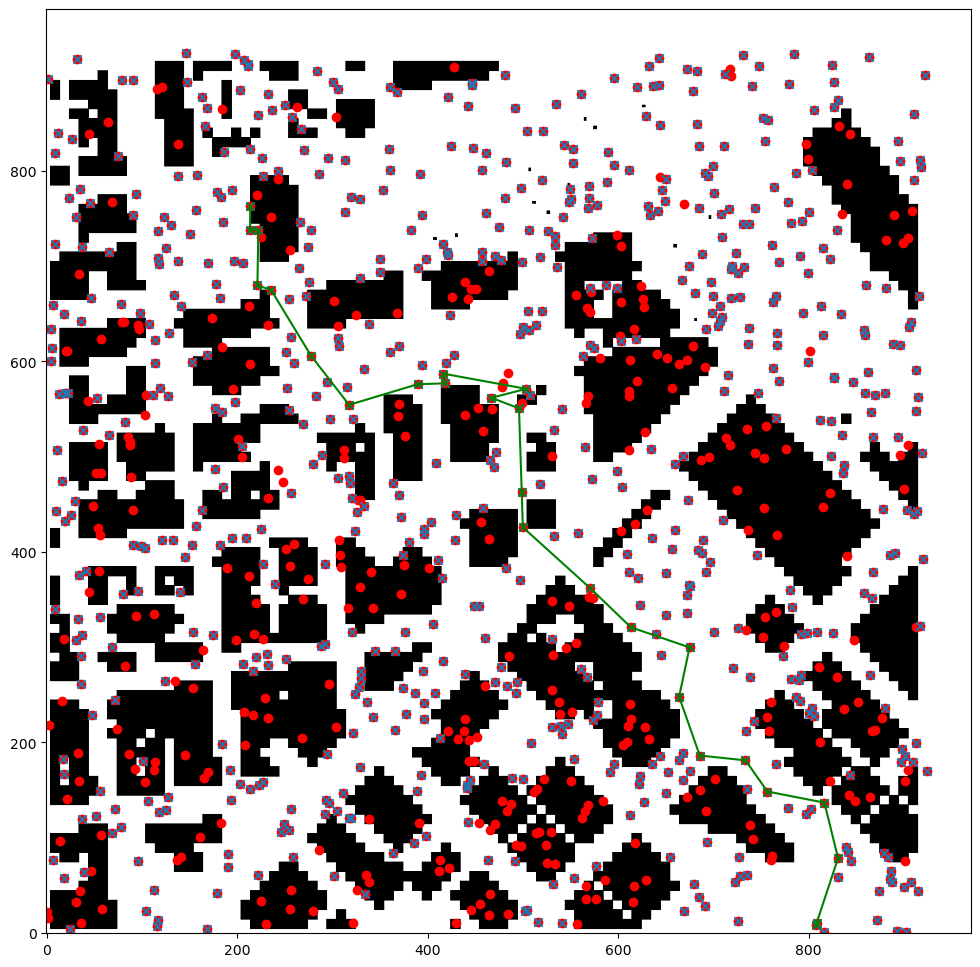

In [143]:
plt.rcParams['figure.figsize'] = 12, 12
fig = plt.figure()
plt.imshow(grid, cmap="Greys", origin="lower")

all_points = np.array(samples)
north_vals = all_points[:,0]
east_vals = all_points[:,1]
plt.scatter(east_vals, north_vals, c='red', alpha=1)

a_points = np.array(keep)
n_vals = a_points[:,0]
e_vals = a_points[:,1]
plt.scatter(e_vals, n_vals, marker='x', alpha=1)
"""
# Use build_graph_from_edges with a list of ((x1,y1),(x2,y2)) to generate an NX graph object with connected points. 
for node in keep:
    pass
edges
"""
"""
for i in range(len(path)-1):
    p1 = path[i]
    p2 = path[i+1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'r-')
"""    
X=[]
Y=[]
for i in path:
    x = keep[i][1]
    y = keep[i][0]
    X.append(x)
    Y.append(y)
plt.plot(X,Y,'gx-')

In [190]:
#plt.plot([1,2,3],[10,10,10])
# generate a graph by querying nearest neighbords in the keep tree.
print(keep_tree)
print(len(keep))

e = []
w = []
for j in range(len(keep)):
    n = keep[j]
    dist, ind = keep_tree.query([n], k=10)
    for i in ind[0]:
        x1 = int(n[0])
        y1 = int(n[1])
        x2 = int(keep[i][0])
        y2 = int(keep[i][1])
        trace = bresenham(x1,y1,x2,y2)
        hit = False
        for t in trace:
            if t[0] < 0 or t[0] >= s[0] or t[1] < 0 or t[1] >= s[1]:
                hit = True
            if not hit:
                if grid[t[0], t[1]] == 1:
                    hit = True        
        if not hit:
            w.append(np.sqrt((x2-x1)**2 + (y2-y1)**2))
            e.append([j, i])

print(len(e))
print(len(w))

print(e[0])
sampling_graph = nx.Graph()
for i in range(len(e)):
    sampling_graph.add_edge(e[i][0],e[i][1],weight=w[i])



680
5158
5158
[0, 0]


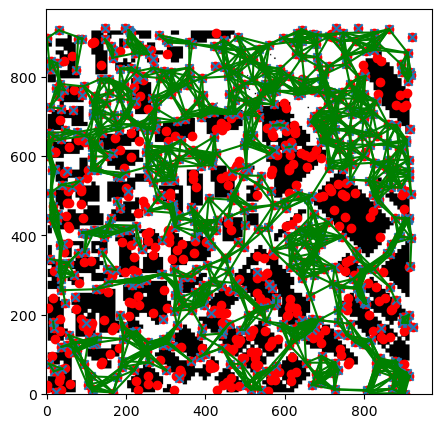

In [192]:
sampling_graph.edges
plt.rcParams['figure.figsize'] = 5, 5
fig = plt.figure()
plt.imshow(grid, cmap="Greys", origin="lower")

all_points = np.array(samples)
north_vals = all_points[:,0]
east_vals = all_points[:,1]
plt.scatter(east_vals, north_vals, c='red', alpha=1)

a_points = np.array(keep)
n_vals = a_points[:,0]
e_vals = a_points[:,1]
plt.scatter(e_vals, n_vals, marker='x', alpha=1)

for e in sampling_graph.edges:
    plt.plot([keep[e[0]][1], keep[e[1]][1]],[keep[e[0]][0],keep[e[1]][0]],'g-')

In [196]:
sampling_graph.adj


"""
def astar_graph(graph, start, goal, h):
    """
    Summary
    This function searches a graph using the A Star search algorithm. 
    
    Inputs
        graph: a graph data structure to search
        start: a (North, East) 2-tuple representing the start location
        goal: a (North, East) 2-tuple representing the goal location
        h: a heuristic function
    Outputs
        path: list of 2-tuples representing the nodes traversed in sequence. 
        cost: the total cost of taking the returned path
    """
    
    # Initialize important containing variables first. Leverage the Priority Queue data structure.
    q = PriorityQueue()
    path = []
    path_cost = 0
    q.put((0, start))
    visited = set(start)
    branch = {}
    found = False
    
    # Next, consider nodes adjacent to the node in question, starting from the start node. Compute the cost of traveling to each and prioritize nodes
    # based on that amount. 
    while not q.empty():
        item = q.get()
        current_node = item[1]
        if current_node == start:
            current_cost = 0.0
        else:              
            current_cost = branch[current_node][0]
        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for key in graph.adj[current_node]:
                next_node = key
                branch_cost = current_cost + Graph.adj[current_node][next_node]['weight']
                queue_cost = branch_cost + h(next_node, goal)
                
                if next_node not in visited:
                    visited.add(next_node)
                    branch[next_node] = (branch_cost, current_node)
                    q.put((queue_cost, next_node))
   
    # Last, build a list of to represent the path traversed from start to goal when one is found.
    if found:
        n = goal
        path_cost = branch[n][0]
        path.append(goal)
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(start)
    else:
        print('************')
        print('Failed to find a path.')
        print('************')
        
    return path[::-1], path_cost
"""

AdjacencyView({0: {0: {'weight': 0.0}, 662: {'weight': 11.704699910719626}, 97: {'weight': 28.0178514522438}}, 662: {0: {'weight': 11.704699910719626}, 97: {'weight': 17.26267650163207}, 662: {'weight': 0.0}}, 97: {0: {'weight': 28.0178514522438}, 97: {'weight': 0.0}, 662: {'weight': 17.26267650163207}}, 1: {1: {'weight': 0.0}, 201: {'weight': 14.317821063276353}, 445: {'weight': 35.4400902933387}}, 201: {1: {'weight': 14.317821063276353}, 66: {'weight': 28.231188426986208}, 201: {'weight': 0.0}, 445: {'weight': 21.18962010041709}, 326: {'weight': 57.28001396647874}}, 445: {1: {'weight': 35.4400902933387}, 20: {'weight': 57.48912940721924}, 62: {'weight': 25.179356624028344}, 66: {'weight': 18.973665961010276}, 197: {'weight': 46.09772228646444}, 201: {'weight': 21.18962010041709}, 265: {'weight': 60.00833275470999}, 326: {'weight': 36.138621999185304}, 374: {'weight': 24.839484696748443}, 445: {'weight': 0.0}, 529: {'weight': 54.0}}, 2: {2: {'weight': 0.0}, 500: {'weight': 28.86173937

In [106]:
print(samples[:10])

"""
Build an A Star algorithm to traverse randomly generated sample nodes. 
Input a 2d map of 0 and 1 to at a given altitude to represent free/obstacle space.
Input a start node and a goal node. They both must match nodes in the sample list.
Search using a straight-line distance by default. 
To get candidate nodes, first find 5-10 nearest neighbors. Then filter those using
a Bresenham routine to determine which are viable, then which are cheapest. 
Build a chronologically-ordered list of nodes that I end up visiting.
Return it, along with the total cost of the search, or return a message about
failing to find a path. 
"""

def astar_sample_points(grid, s, samples, sample_tree, start, goal):
    """
    grid numpy float nx6
    sample_tree KDTree of sample (x, y, h)
    start tuple (xo, yo)
    goal tuple (xf, yf)
    h function
    assume start and goal are in sample_tree
    """
    

    # How many nearest neighbors to consider before filtering them down using a Bresenham routine. 
    k = 20
    
    q = PriorityQueue()
    start_index = start
    goal_index = goal
    
    q.put((0,start_index))
    visited = set()
    visited.add(start_index)
    path = []
    path.append(start_index)
    found = False
    cost = 0
    # Start a routine 
    while not q.empty():
        item = q.get()
        print('item:')
        print(item)
        substart_i = item[1]
        if substart_i != start_index:
            path.append(substart_i)
            cost += item[0]
        if substart_i == goal_index:
            print('Found a path')
            found = True
            break
        
        dist, ind = keep_tree.query([keep[substart_i]], k)
        for i in ind[0]:
            if i not in visited:
                p1 = samples[substart_i]
                p2 = samples[i]
                x1 = int(p1[0])
                y1 = int(p1[1])
                x2 = int(p2[0])
                y2 = int(p2[1])
                trace = bresenham(x1,y1,x2,y2)
                hit = False
                for p in trace:
                    if p[0] < 0 or p[0] >= s[0] or p[1] < 0 or p[1] >= s[1]:
                        hit = True
                    if not hit:
                        if grid[p[0], p[1]] == 1:
                            hit = True        
                if not hit:
                    visited.add(i)
                    subcost = np.sqrt((x2-x1)**2+(y2-y1)**2)
                    heuristic_cost = np.sqrt((x2-samples[goal_index][0])**2+(y2-samples[goal_index][1])**2)
                    q.put( (subcost + heuristic_cost, i) )

    if found:
        print(path)
        print(cost)
    else:
        print('Failed to find path')
    
    return path, cost

start_i = 10
end_i = 50
print(keep[start_i])
print(keep[end_i])
path, cost = astar_sample_points(grid, s, keep, keep_tree, start_i, end_i)
            
           
            
            
            
"""                                    
    for candidate_subpath in candidate_subpaths:
        x1 = candidate_subpath[0][0]
        y1 = candidate_subpath[0][1]
        x2 = candiate_subpath[1][0]
        y2 = candidate_subpath[1][1]
        subcosts.append(np.sqrt((x2-x1)**2+(y2-y1)**2))
    
"""

"""
def find_closest_vertex(given_vertex, vertices):
    
    #Given a (North, East) 2-tuple coordinate pair and a list of 2-tuples containing (North, East) pairs, return the pair in the latter closest to the former.
    
    distance = 1000000
    for vertex in vertices:
        d = np.sqrt((given_vertex[0]-vertex[0])**2 + (given_vertex[1]-vertex[1])**2)
        if d < distance:
            distance = d
            closest_vertex = (vertex[0], vertex[1])
    return closest_vertex
    -----------------------
    # Initialize important containing variables first. Leverage the Priority Queue data structure.
    q = PriorityQueue()
    path = []
    path_cost = 0
    q.put((0, start))
    visited = set(start)
    branch = {}
    found = False
    
    # Next, consider nodes adjacent to the node in question, starting from the start node. Compute the cost of traveling to each and prioritize nodes
    # based on that amount. 
    while not q.empty():
        item = q.get()
        current_node = item[1]
        if current_node == start:
            current_cost = 0.0
        else:              
            current_cost = branch[current_node][0]
        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for key in graph.adj[current_node]:
                next_node = key
                branch_cost = current_cost + Graph.adj[current_node][next_node]['weight']
                queue_cost = branch_cost + h(next_node, goal)
                
                if next_node not in visited:
                    visited.add(next_node)
                    branch[next_node] = (branch_cost, current_node)
                    q.put((queue_cost, next_node))
   
    # Last, build a list of to represent the path traversed from start to goal when one is found.
    if found:
        n = goal
        path_cost = branch[n][0]
        path.append(goal)
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(start)
    else:
        print('************')
        print('Failed to find a path.')
        print('************')
        
    return path[::-1], path_cost
    --------
"""

[[676.68889097 598.67506977  10.        ]
 [119.18268936  37.45383121  10.        ]
 [261.4610865  296.42912732  10.        ]
 [235.34096061 836.84519608  10.        ]
 [392.73419388 919.61826876  10.        ]
 [564.74536439 507.67509738  10.        ]
 [146.28650505 650.32222298  10.        ]
 [566.57394622 858.69970545  10.        ]
 [618.06752588 736.33634279  10.        ]
 [235.90489133 879.94757713  10.        ]]
[763.10223887 213.62426992  10.        ]
[  8.15323268 808.0851017   10.        ]
item:
(0, 10)
item:
(966.7019602969093, 136)
item:
(944.3165019722675, 202)
item:
(951.00179288598, 522)
item:
(893.8276107753848, 338)
item:
(880.5560067061364, 45)
item:
(799.0584536342235, 479)
item:
(781.035562002663, 258)
item:
(718.3324184851249, 351)
item:
(728.2930197686612, 540)
item:
(728.6725903380194, 124)
item:
(688.4519584520481, 283)
item:
(656.8117785128279, 377)
item:
(637.5409021568597, 381)
item:
(556.9494017160199, 496)
item:
(521.2463889633441, 229)
item:
(427.25426199256

"\ndef find_closest_vertex(given_vertex, vertices):\n    \n    #Given a (North, East) 2-tuple coordinate pair and a list of 2-tuples containing (North, East) pairs, return the pair in the latter closest to the former.\n    \n    distance = 1000000\n    for vertex in vertices:\n        d = np.sqrt((given_vertex[0]-vertex[0])**2 + (given_vertex[1]-vertex[1])**2)\n        if d < distance:\n            distance = d\n            closest_vertex = (vertex[0], vertex[1])\n    return closest_vertex\n    -----------------------\n    # Initialize important containing variables first. Leverage the Priority Queue data structure.\n    q = PriorityQueue()\n    path = []\n    path_cost = 0\n    q.put((0, start))\n    visited = set(start)\n    branch = {}\n    found = False\n    \n    # Next, consider nodes adjacent to the node in question, starting from the start node. Compute the cost of traveling to each and prioritize nodes\n    # based on that amount. \n    while not q.empty():\n        item = q.g

In [ ]:
# Try to optimize the collision checking by using a KDTree to store
# the randomly generated points. 


# The connect the points using a graph algorithm. This basically will create a 3d graph. 

# In the receeding horizon planner, I should combine 2d a star with 3d a star. First I should 
# plan a 2d trajectory from start to goal. Then I should pretend to be located at a given 
# x,y,z waypoint along the path. I should use random sampling to generate a viable 3d graph 
# within a given 3d box around that point. The 3d planner should be able to be called like 
# a function, multiple times from another function given a current waypoint and end node. 
# The 3d end node should be the intersection point of the boundary box with the original path. By
# setting planning up in this way, I'd be able to have the drone replan it's trajectory any
# time it senses that it has the need, like when it senses it's off course. 


C:\Users\Ronen\AppData\Local\Temp\ipykernel_14356\3323417703.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


{(0, 0, 3): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x184c8f58d90>,
 (0, 1, 3): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x184c8f66250>}

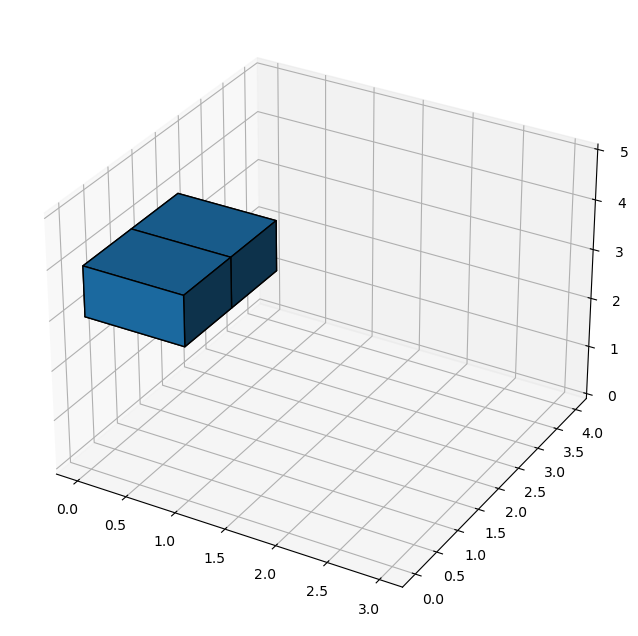

In [208]:
fig = plt.figure()
ax = fig.gca(projection='3d')
a = np.zeros((3,4,5))
a[0,0:2,3] = 1
ax.voxels(a, 
          edgecolor='k')

In [87]:
def create_voxmap(data, voxel_size=10):
    """
    Inputs: 
        data: n x 6 numpy array, contains obstacle geometry. Each row of the data numpy
            array contains columns with this information: PosX, PosY, PosZ, HalfX, HalfY, HalfZ.
    """
    # First, measure the dimensions of the obstacle data.
    r = [0,0,0,0,0,0]
    r[0] = int(np.floor(np.amin(data[:,0] - data[:,3]))) #North min
    r[1] = int(np.ceil(np.amax(data[:,0] + data[:,3]))) #North max
    r[2] = int(np.floor(np.amin(data[:,1] - data[:,4]))) #East min
    r[3] = int(np.ceil(np.amax(data[:,1] + data[:,4]))) #East max
    r[4] = int(np.floor(np.amin(data[:,2] - data[:,5]))) #Alt min
    r[5] = int(np.ceil(np.amax(data[:,2] + data[:,5]))) #Alt max
    offset = [0,0]
    offset[0] = int(np.amin(data[:,0])) #North offset
    offset[1] = int(np.amin(data[:,1])) #East offset
    
    # Calculate the size of the configuration space next. Scale it down in each direction by the scaling factor.
    s = [0,0,0]
    s[0] = (r[1] - r[0]) // voxel_size 
    s[1] = (r[3] - r[2]) // voxel_size
    s[2] = (r[5] - r[4]) // voxel_size
    
    # Intialize an empty configuration space spacial array. Then populate it with obstacles.
    configuration = np.full((s[0], s[1], s[2]), False, dtype=bool) 
    for i in range(data.shape[0]):
        north, east, alt, d_north, d_east, d_alt = data[i,:]
        c = [int(np.rint(north - r[0] - d_north)) // voxel_size,
             int(np.rint(north - r[0] + d_north)) // voxel_size,
             int(np.rint(east - r[2] - d_east)) // voxel_size,
             int(np.rint(east - r[2] + d_east)) // voxel_size,
             int(np.rint(alt - r[4] - d_alt)) // voxel_size,
             int(np.rint(alt - r[4] + d_alt)) // voxel_size
            ]
        configuration[c[0]:c[1]+1, c[2]:c[3]+1, c[4]:c[5]+1] = True
        
    return configuration

data = read_obstacle_data('colliders.csv')
voxel_size = 5
voxmap = create_voxmap(data, voxel_size)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(voxmap,alpha=1)
ax.set_xlim(voxmap.shape[0], 0)
ax.set_ylim(0, voxmap.shape[1])
ax.set_zlim(0, voxmap.shape[2]+3)
for i in range(len(keep)):
    ax.scatter(keep[i][1] // voxel_size ,keep[i][0] // voxel_size ,keep[i][2] // voxel_size, c='red', marker='x', alpha=1)
plt.xlabel('Northings')
plt.ylabel('Eastings')
plt.title('Voxel size ' + str(voxel_size))

ax.view_init(60, 60)
plt.show()

C:\Users\Ronen\AppData\Local\Temp\ipykernel_41752\1477925689.py:44: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


KeyboardInterrupt: 

AttributeError: 'PathCollection' object has no attribute 'do_3d_projection'

<Figure size 640x480 with 1 Axes>

Found a path.


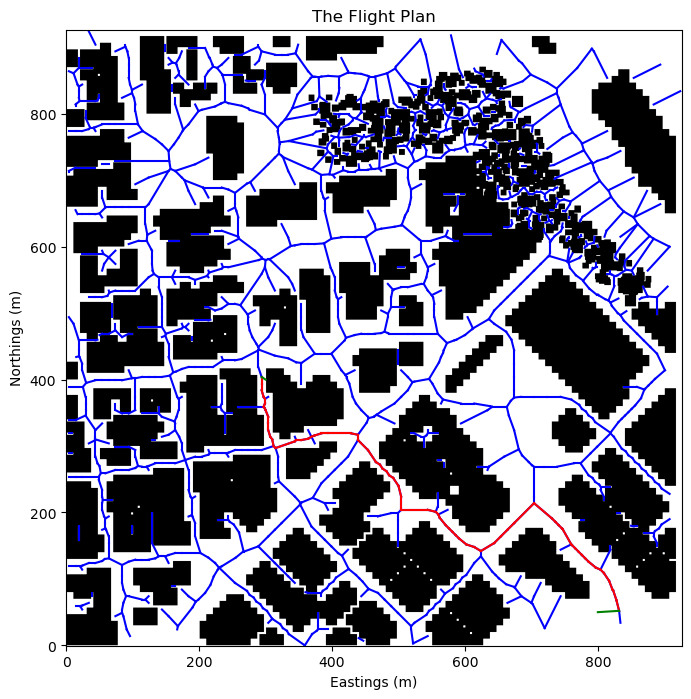

Graph with 1677 nodes and 1653 edges


In [255]:
"""
This code block will contain an A* search algorithm that 
works on graph data structures. 
"""
def h(n1, n2):
    """
    Computes and returns the straight line distance between two 2-tuple nodes given their (north, east) coordinates.
    """
    return np.sqrt((n1[0]-n2[0])**2+(n1[1]-n2[0])**2)

def find_closest_vertex(given_vertex, vertices):
    """
    Given a (North, East) 2-tuple coordinate pair and a list of 2-tuples containing (North, East) pairs, return the pair in the latter closest to the former.
    """
    distance = 1000000
    for vertex in vertices:
        d = np.sqrt((given_vertex[0]-vertex[0])**2 + (given_vertex[1]-vertex[1])**2)
        if d < distance:
            distance = d
            closest_vertex = (vertex[0], vertex[1])
    return closest_vertex
            
def astar_graph(graph, start, goal, h):
    """
    Summary
    This function searches a graph using the A Star search algorithm. 
    
    Inputs
        graph: a graph data structure to search
        start: a (North, East) 2-tuple representing the start location
        goal: a (North, East) 2-tuple representing the goal location
        h: a heuristic function
    Outputs
        path: list of 2-tuples representing the nodes traversed in sequence. 
        cost: the total cost of taking the returned path
    """
    
    # Initialize important containing variables first. Leverage the Priority Queue data structure.
    q = PriorityQueue()
    path = []
    path_cost = 0
    q.put((0, start))
    visited = set(start)
    branch = {}
    found = False
    
    # Next, consider nodes adjacent to the node in question, starting from the start node. Compute the cost of traveling to each and prioritize nodes
    # based on that amount. 
    while not q.empty():
        item = q.get()
        current_node = item[1]
        if current_node == start:
            current_cost = 0.0
        else:              
            current_cost = branch[current_node][0]
        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for key in graph.adj[current_node]:
                next_node = key
                branch_cost = current_cost + Graph.adj[current_node][next_node]['weight']
                queue_cost = branch_cost + h(next_node, goal)
                
                if next_node not in visited:
                    visited.add(next_node)
                    branch[next_node] = (branch_cost, current_node)
                    q.put((queue_cost, next_node))
   
    # Last, build a list of to represent the path traversed from start to goal when one is found.
    if found:
        n = goal
        path_cost = branch[n][0]
        path.append(goal)
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(start)
    else:
        print('************')
        print('Failed to find a path.')
        print('************')
        
    return path[::-1], path_cost

start = (400,300)
goal = (50,800)
path, cost = astar_graph(Graph,  find_closest_vertex(start, Graph.nodes), find_closest_vertex(goal, Graph.nodes), h)
#(400, 300), (400, 558)
#print(path)
#print(cost)

plt.imshow(grid, cmap='Greys', origin="lower")
plt.rcParams["figure.figsize"] = [8, 8]

# Plot the results of the A Star graph search. 
plt.imshow(grid, cmap='Greys', origin='lower')

for edge in edges:
    p1 = edge[0]
    p2 = edge[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')
        
for i in range(len(path)-1):
    p1 = path[i]
    p2 = path[i+1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'r-')

plt.plot([start[1], path[0][1]],[start[0], path[0][0]],'g-')
plt.plot([goal[1], path[-1][1]],[goal[0], path[-1][0]],'g-')

plt.xlabel('Eastings (m)')
plt.ylabel('Northings (m)')
plt.title('The Flight Plan')
plt.show()
print(Graph)

In [21]:
#Graph.adj[(62, 558)][(58,552)]['weight']
#print(Graph.nodes)

In [ ]:
"""
This section contains code related to A* Search.
"""
class Action(Enum):
    """
    This class defines the action set. Each action is a 3-element tuple where the first two elements describe
    the vertical and horizontal grid motions or translations, while the final element of the tuple describes
    the action's cost. 
    
    """
    LEFT = (0, -1, 1)
    RIGHT = (0, 1, 1)
    UP = (-1, 0, 1)
    DOWN = (1, 0, 1)
    NORTHEAST = (-1, 1, np.sqrt(2))
    NORTHWEST = (-1, -1, np.sqrt(2))
    SOUTHEAST = (1, 1, np.sqrt(2))
    SOUTHWEST = (1, -1, np.sqrt(2))
    
    def __str__(self):
        if self == self.LEFT:
            return '<'
        elif self == self.RIGHT:
            return '>'
        elif self == self.UP:
            return '^'
        elif self == self.DOWN:
            return 'v'
        elif self == self.NORTHEAST:
            return '*'
        elif self == self.NORTHWEST:
            return '*'
        elif self == self.SOUTHEAST:
            return '*'
        elif self == self.SOUTHWEST:
            return '*'
        
    @property
    def cost(self):
        return self.value[2]
    @property
    def delta(self):
        return (self.value[0], self.value[1])

def valid_actions(grid, current_node):
    """
    Returns a list of valid actions given a grid and given a node. Input grid is a nxm bool numpy array, representing the configuration space.
    Input current_node is a grid cell tuple. This function returns a list of valid actions, from the potential actions defined in the action class,
    stemming from the given cell.
    """
    
    # This function defines some key parameters first.
    potential = [Action.UP, Action.LEFT, Action.RIGHT, Action.DOWN, Action.NORTHEAST, Action.NORTHWEST, Action.SOUTHEAST, Action.SOUTHWEST]
    #potential = [Action.UP, Action.LEFT, Action.RIGHT, Action.DOWN]
    valid = []
    n, m = grid.shape[0] - 1, grid.shape[1] - 1
    x, y = current_node
    
    # Next, it iterates through each potential action, only considering it as a valid action if the action results in a location that is both on-grid and
    # non-obstacle.
    for action in potential:
        dx, dy = action.value[0], action.value[1]
        rx, ry = x + dx, y + dy
        if rx <= n and rx >= 0 and ry <=m and ry >= 0 and grid[rx, ry] != True:
            valid.append(action)
        
    
    # Finally, this function returns a list of valid actions.     
    return valid

def visualize_path(grid, path, start):
    """
    Given a grid, path, start node, returns a string grid representation. This function isn't used much anymore. 
    """
    sgrid = np.zeros(np.shape(grid), dtype=str)
    sgrid[:] = ' '
    sgrid[grid[:] == 1] = 'O'
    
    pos = start
    for a in path:
        da = a.value
        sgrid[pos[0] + da[0], pos[1] + da[1]] = str(a)
        pos = (pos[0] + da[0], pos[1] + da[1])
    sgrid[pos[0], pos[1]] = 'G'
    sgrid[start[0], start[1]] = 'S'
    
    return sgrid

def visualize_path_waypoints(sgrid):
    """
    This function visualizes the search solution, but don't use this anymore.
    """
    vis = np.zeros(np.shape(sgrid))
    for i in range(np.shape(vis)[0]):
        for j in range(np.shape(vis)[1]):
            if sgrid[i,j] in ['S', 'G', '<', '>', 'v', '^', '*']:
                vis[i, j] = 10
            elif sgrid[i,j] == 'O':
                vis[i, j] = 1
    plt.imshow(vis, origin='lower', cmap="gray")
    
    return

def plot_waypoints(grid, waypoints, start_ne, goal_ne):
    plt.imshow(grid, cmap='Greys', origin='lower')
    plt.plot(start_ne[1], start_ne[0], 'x')
    plt.plot(goal_ne[1], goal_ne[0], 'x')
    if waypoints is not None:
        plt.plot(culled_waypoints[:,1], culled_waypoints[:,0], 'g')
        plt.scatter(culled_waypoints[:,1], culled_waypoints[:,0])
        plt.xlabel('Eastings (m)')
        plt.ylabel('Northings (m)')
        plt.show()
    return

def euclidean_heuristic(position, goal_position):
    """
    Computes and returns the straight-line distance between the a given node and a goal node.
    """
    h = np.sqrt((position[0] - goal_position[0])**2 + (position[1] - goal_position[1])**2) 
    return h

def manhattan_heuristic(position, goal_position):
    """
    Computes and returns the Manhattan distance between the given node and a goal node.
    """
    h = np.abs(position[0] - goal_position[0]) + np.abs(position[1] - goal_position[1])
    return h

def path_to_waypoints(start, path):
    """
    Returns an array of waypoints given the start node and the path. 
    Input: 1x2 tuple start, list path
    """
    waypoints = np.array([start[0], start[1], 1])
    current_node = np.array([start[0], start[1], 1])
    previous_node = None
    
    for i in range(len(path)):
        dx = path[i].value[0]
        dy = path[i].value[1]
        next_node = np.array([current_node[0] + dx, current_node[1] + dy, 1])
        waypoints = np.vstack((waypoints, next_node))
        current_node = next_node
    return waypoints

def remove_collinear_waypoints(waypoints):
    """
    This function is an algorithm that removes unneeded collinear waypoints. 
    Input: waypoints, n x 3 numpy array
    Returns: culled_waypoints, n x 3 numpy array
    """
    i = 0
    while i+2 < len(waypoints):
        points = np.array([waypoints[i], waypoints[i+1], waypoints[i+2]])
        #collinear = np.linalg.det(points) <= np.abs(0.01)
        x1, x2, x3 = waypoints[i,0], waypoints[i+1,0], waypoints[i+2,0]
        y1, y2, y3 = waypoints[i,1], waypoints[i+1,1], waypoints[i+2,1]
        collinear = x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2) == 0
        if collinear: 
            waypoints = np.delete(waypoints, i+1, 0)
        else:
            i += 1
    
    return waypoints

def a_star(grid, h, start, goal):
    """
    Executes A Star Search given a grid, heuristic array, a start goal, and an end goal. 
    Returns the path if one is found and the associated cost. 
    """
    
    # First, initializes data structures.
    path = []
    path_cost = 0
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)
    branch = {}
    found = False
    
    # Then, begin the A Star. The algorithm will expand the lowest queue-cost node, where queue-cost
    # is the sum of the heuristic cost and the path cost. 
    while not queue.empty():
        item = queue.get()
        current_node = item[1]
        
        if current_node == start:
            current_cost = 0.0
        else:
            current_cost = branch[current_node][0]
        
        if current_node == goal:
            print('Found a path.')
            found = True
            break
        else:
            for action in valid_actions(grid, current_node):
                da = action.delta
                next_node = (current_node[0] + da[0], current_node[1] + da[1])
                branch_cost = current_cost + action.cost
                queue_cost = branch_cost + h(next_node, goal)
                
                if next_node not in visited:
                    visited.add(next_node)
                    branch[next_node] = (branch_cost, current_node, action)
                    queue.put((queue_cost, next_node))
    
    # After, retraces steps, returning the step-by-step actions and total path-cost required to get there.
    if found:
        n = goal
        path_cost = branch[n][0]
        while branch[n][1] != start:
            path.append(branch[n][2])
            n = branch[n][1]
        path.append(branch[n][2])
    else:
        print('************')
        print('Failed to find a path.')
        print('************')
    
    # Return a step-by-step list of actions taken from start to goal, given one is found. Also return the total associated path cost. 
    return path[::-1], path_cost

def find_closest_ma_node(grid_node, medial_axis_map):
    """
    Given a medial-axis obstacle map and a point coordinate, return the closest medial-axis coordinate.
    """
    x, y = grid_node[0], grid_node[1]
    if medial_axis_map[x,y] == 0:
        return (x, y)
    dx, dy = 1, 1
    i = 0
    m = [1, 1, 1, 1]
    while np.sum(m) == 4:
        i += 1
        m[0] = medial_axis_map[x+i*dx, y]
        m[1] = medial_axis_map[x-i*dx, y]
        m[2] = medial_axis_map[x, y+i*dy]
        m[3] = medial_axis_map[x, y-i*dy]
        
        
    print(i)
    for j in range(4):
        if m[j] == 0:
            if j == 0:
                return (x+i*dx, y)
            elif j == 1:
                return (x-i*dx, y)
            elif j == 2:
                return (x, y+i*dy)
            elif j == 3:
                return (x, y-i*dy)

In [ ]:
# Now, generate a configuration space in 2d from obstacle map.
data = read_obstacle_data('colliders.csv')
drone_altitude = 5
safe_distance = 3
grid = create_grid(data, drone_altitude, safe_distance)

# Display the configuration space at the specified altitude
plt.rcParams['figure.figsize'] = 12, 12

# After that, set the start and goal map locations. 
start_ne = (25, 100)
goal_ne = (650, 120)

# With the start and end locations set, solve the planning problem using A* search.
path, cost = a_star(grid, euclidean_heuristic, start_ne, goal_ne)
waypoints = path_to_waypoints(start_ne, path)
print('The cost is ' + str(cost))
print('The number of steps is ' + str(len(path)))

# Once the search is finished, remove collinear waypoints. 
culled_waypoints = remove_collinear_waypoints(waypoints)
print('The number of culled waypoints is ' + str(len(culled_waypoints)))

# Finally, plot the solution.
plot_waypoints(grid, culled_waypoints, start_ne, goal_ne)



In [ ]:
# Now, add sophistication to the planning problem by defining safe fly-routes using a method
# callled the medial-axis transform. 

# Transform the grid with the medial axis algorithm
skeleton = medial_axis(invert(grid))
skeleton = invert(skeleton)

# Begin setting up the planning problem. Define a start and goal. 
start_ne = (50, 50)
goal_ne = (500, 500)

# Find the closest medial axis nodes to the desired start and goal.
start_ne = find_closest_ma_node((1, 1), skeleton)
goal_ne = find_closest_ma_node((900, 900), skeleton)

# Run A* search across the medial-axis transformed grid. Once the search is finished, remove collinear waypoints. Plot the solution. 
path, cost = a_star(skeleton, euclidean_heuristic, start_ne, goal_ne)
print('The cost is ' + str(cost))
print('The number of steps is ' + str(len(path)))
waypoints = path_to_waypoints(start_ne, path)
culled_waypoints = remove_collinear_waypoints(waypoints)
print('The number of culled waypoints is ' + str(len(culled_waypoints)))
plot_waypoints(skeleton, culled_waypoints, start_ne, goal_ne) 

# Also run A* search on the original grid, before medial axis tranform, just for comparison. Remove collinear waypoints and plot the solution.
start_ne = (0, 0)
goal_ne = (250, 500)
path, cost = a_star(grid, euclidean_heuristic, start_ne, goal_ne)
waypoints = path_to_waypoints(start_ne, path)
print('The cost is ' + str(cost))
print('The number of steps is ' + str(len(path)))
culled_waypoints = remove_collinear_waypoints(waypoints)
print('The number of culled waypoints is ' + str(len(culled_waypoints)))
plot_waypoints(grid, culled_waypoints, start_ne, goal_ne)

print(culled_waypoints)

In [ ]:

points = np.random.randint(50, size=(50, 2))
graph = Voronoi(points)
voronoi_plot_2d(graph)
plt.show()
print(graph.vertices)
print(graph.ridge_vertices)